In [3]:
import time
import neo4j
import pandas as pd
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt

### Connect to small database

In [4]:
NEO4J_URI = "bolt://localhost:7690"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "graph-routing"
NEO4J_DATABASE = "neo4j"

driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DATABASE)

### Get result helper function

In [13]:
def print_result(results):
    result = [dict(i) for i in results]
    print(result)
    
    result_all = results.consume()
    print(f"result_consumed_after: {result_all.result_consumed_after} ms")
    print(f"result_available_after: {result_all.result_available_after} ms\n")

### Check database numbers

In [11]:
storage_query = """
    CALL apoc.monitor.store() 
    YIELD 
        logSize, 
        stringStoreSize, 
        arrayStoreSize, 
        relStoreSize, 
        propStoreSize, 
        totalStoreSize, 
        nodeStoreSize
    RETURN *
"""

nodes_and_rels_nb_query = """
    CALL apoc.meta.stats() 
    YIELD nodeCount, relCount
    RETURN *
"""

In [9]:
with driver.session() as session:
    results = session.run(storage_query)
    print_result(results)

ClientError: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `apoc.monitor.store` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}

In [14]:
with driver.session() as session:
    results = session.run(nodes_and_rels_nb_query)
    print_result(results)

[{'nodeCount': 333120, 'relCount': 721628}]
result_consumed_after: 9 ms
result_available_after: 5 ms



### Plotting function

In [15]:
def plot_query_times(query_times, save=False, filepath=None):
    query_nb = [i for i in range(1, len(query_times) + 1)]
    plt.plot(query_nb, query_times, marker=".", color="teal")
    plt.xlabel("Query number")
    plt.ylabel("Query execution time [ms]")
    
    if save:
        plt.show()
        plt.savefig(filepath, bbox_inches="tight", dpi=200)
        plt.close()
        
    else:
        plt.show()

### Nodes selection

In [16]:
nodes = pd.read_csv("./data/krakow/nodes_neo4j.csv")

In [17]:
# two random osmid
distance_small = 0
osmid_1_small = 0
osmid_2_small = 0

while distance_small < 25:
    start_and_finish = nodes.sample(2)

    osmid_1_small = int(start_and_finish.iloc[0]["osmid"])
    osmid_2_small = int(start_and_finish.iloc[1]["osmid"])

    coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
    coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
    distance_small = geopy.distance.distance(coords_1, coords_2).km

print(f"osmid_1_small: {osmid_1_small}, osmid_2_small: {osmid_2_small}, distance: {distance_small} km")

osmid_1_small: 9589826850, osmid_2_small: 9723732263, distance: 28.247114621190956 km


### Paths queries and parsing query time

In [19]:
def parse_query_time(results):
    _ = [dict(i) for i in results]
    result_all = results.consume()
    return int(result_all.result_consumed_after)

In [20]:
def dijkstra_query(tx, osmid_1, osmid_2):
    dijkstra_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2}}})
        CALL apoc.algo.dijkstra(source, target, "", "length")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(dijkstra_query_string)
    query_time = parse_query_time(results)
    return query_time
    
def astar_query(tx, osmid_1, osmid_2):
    astar_query_string = f"""
        MATCH (source:Intersection {{osmid: {osmid_1}}}) 
        MATCH (target:Intersection {{osmid: {osmid_2}}})
        CALL apoc.algo.aStar(source, target, "", "length", "latitude", "longitude")
        YIELD path, weight
        RETURN path, weight
        """
    results = tx.run(astar_query_string)
    query_time = parse_query_time(results)
    return query_time

### How many queries

In [21]:
query_number = 30

### Djikstra small distance, small database

In [25]:
with driver.session() as session:
    query_time = session.execute_write(dijkstra_query, osmid_1_small, osmid_2_small)

print(f"query times: {query_time}")

query times: 6665


Query: 100%|██████████| 30/30 [04:58<00:00,  9.94s/it]

queries times: [7912, 11526, 9485, 6556, 9376, 12144, 7744, 11564, 7863, 11839, 9095, 11753, 9648, 11575, 11677, 6994, 11727, 7621, 11522, 12722, 6919, 10701, 11324, 7441, 11253, 10655, 6661, 9954, 11528, 6096]


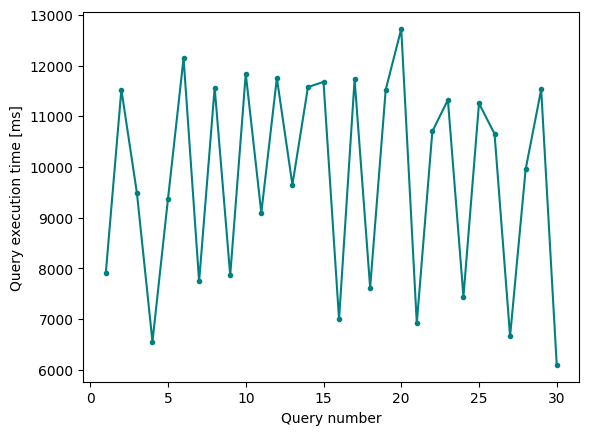

In [26]:
djikstra_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query, osmid_1_small, osmid_2_small)
        djikstra_query_times.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {djikstra_query_times}")

plot_query_times(djikstra_query_times)

### Astar small distance, small database

In [27]:
with driver.session() as session:
    query_time = session.execute_write(astar_query, osmid_1_small, osmid_2_small)

print(f"query times: {query_time} ms")

query times: 775 ms


Query: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]

queries times: [601, 624, 596, 651, 567, 601, 583, 543, 571, 634, 623, 589, 566, 548, 566, 563, 557, 598, 602, 583, 574, 543, 631, 548, 546, 561, 568, 542, 544, 538]


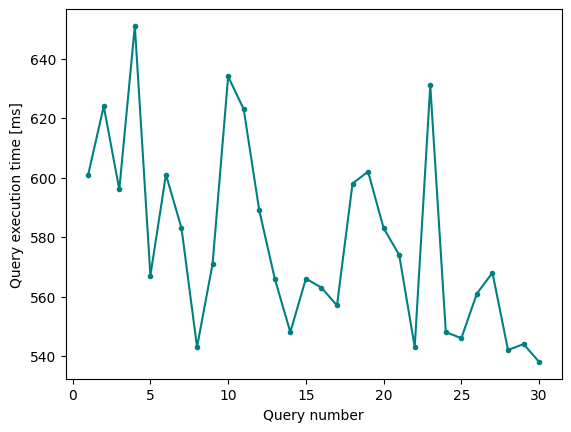

In [28]:
astar_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query, osmid_1_small, osmid_2_small)
        astar_query_times.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_query_times}")

plot_query_times(astar_query_times)

### Connect to big database

In [29]:
NEO4J_URI = "bolt://localhost:7690"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "graph-routing"
NEO4J_DATABASE = "neo4j"

driver = neo4j.GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DATABASE)

### Selection of nodes

In [30]:
nodes = pd.read_csv("./data/krakow_big/nodes_neo4j.csv")

In [31]:
distance_big = 0
osmid_1_big = 0
osmid_2_big = 0

while distance_big < 300:
    start_and_finish = nodes.sample(2)

    osmid_1_big = int(start_and_finish.iloc[0]["osmid"])
    osmid_2_big = int(start_and_finish.iloc[1]["osmid"])

    coords_1 = start_and_finish.iloc[0]["y"], start_and_finish.iloc[0]["x"]
    coords_2 = start_and_finish.iloc[1]["y"], start_and_finish.iloc[1]["x"]
    
    distance_big = geopy.distance.distance(coords_1, coords_2).km

print(f"osmid_1_big: {osmid_1_big}, osmid_2_big: {osmid_2_big}, distance: {distance_big} km")

osmid_1_big: 11135757837, osmid_2_big: 5478093202, distance: 312.2738416105581 km


### Check data size and number of records

In [32]:
with driver.session() as session:
    results = session.run(storage_query)
    print_result(results)

ClientError: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `apoc.monitor.store` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}

In [33]:
with driver.session() as session:
    results = session.run(nodes_and_rels_nb_query)
    print_result(results)

[{'nodeCount': 12799075, 'relCount': 26649381}]
result_consumed_after: 147 ms
result_available_after: 210 ms



### Decrease number of queries

In [34]:
query_number = 10

### Djikstra big distance, big database

In [35]:
with driver.session() as session:
    query_time = session.execute_write(dijkstra_query, osmid_1_big, osmid_2_big)

print(f"query times: {query_time}")

In [ ]:
djikstra_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(dijkstra_query, osmid_1_big, osmid_2_big)
        djikstra_query_times.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {djikstra_query_times}")

plot_query_times(djikstra_query_times)

Query:  47%|████▋     | 14/30 [10:02<11:16, 42.29s/it]

### Astar big distance, big database

In [ ]:
with driver.session() as session:
    query_time = session.execute_write(astar_query, osmid_1_big, osmid_2_big)

print(f"query times: {query_time} ms")

In [ ]:
astar_query_times = []

for _ in tqdm(range(query_number), desc="Query"):
    with driver.session() as session:
        query_time = session.execute_write(astar_query, osmid_1_big, osmid_2_big)
        astar_query_times.append(query_time)
    time.sleep(0.1)
    
print(f"queries times: {astar_query_times}")

plot_query_times(astar_query_times)